O objetivo deste arquivo é realizar o pré-processamento conforme formulado no arquivo Parte_3_d.

In [157]:
library(ggplot2)
library(data.table)
library(dplyr)
library(arules)
library(rpart)

In [158]:
dt <- fread("train/train.csv", stringsAsFactor=T)

Antes de mais nada, conforme mencionado em **Parte_1**, algumas instâncias da tabela estão incompletas. Aquelas instâncias que possuem poucos elementos faltantes serão eliminadas.

In [159]:
dt <- dt[SexuponOutcome != '']
dt <- dt[AgeuponOutcome != '']

In [160]:
dt2 <- dt
dt2$Name <- NULL
dt2$DateTime <- NULL
dt2$OutcomeType <- NULL
dt2$OutcomeSubtype <- NULL
dt2$AnimalType <- NULL
dt2$SexuponOutcome <- NULL
dt2$AgeuponOutcome <- NULL
dt2$Breed <- NULL
dt2$Color <- NULL

In [161]:
transformacao.linear <- function (x){
    new.x <- (x - min(x)) / (max(x)-min(x))
    new.x
}

mapeamento <- function (x1, x2, y) {
    mapped <- y[match(x1, x2)]
    mapped
}

## Transformando os Dados

Nesta parte, cada atributo será transformado, e estes novos valores substituirão os valores antigos,
para salvar a tabela concluída em um novo arquivo.

## Name

Fazendo uma nova interpretação sobre o atributo Name. Um animal que não possui nome pode significar que é um animal que não possuiu dono, nem um histórico. Por isso, pode ser que as pessoas tenham receio de adotar um animal sem nome, uma vez que, além disso, não há um histórico sobre o animal (vacinação, comportamento, etc.)

In [162]:
dt$Have_Name <- ifelse(dt$Name == '', 0, 1)
dt2$Name <- dt$Have_Name

Visualizando a separação pelo nome do animal. Caso ele tenha nome, é 1, do contrário, 0.

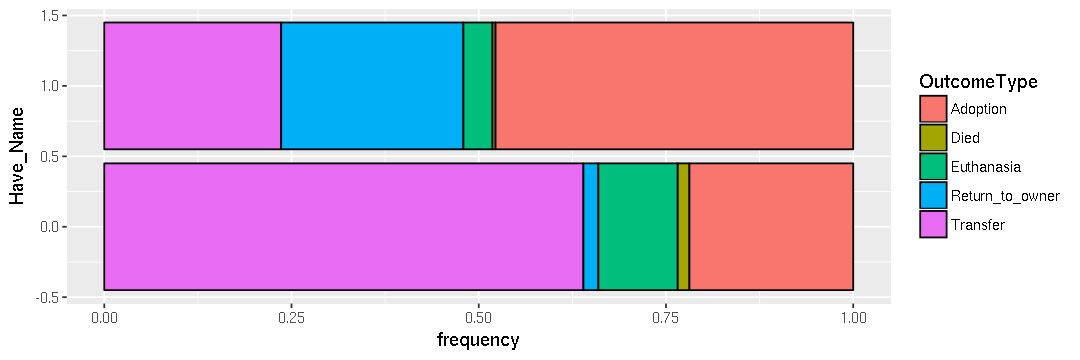

In [163]:
options(repr.plot.width=9, repr.plot.height=3)
outcomes <- dt[1:length(dt$Have_Name),] %>%
group_by(Have_Name, OutcomeType) %>%
summarise(frequency = n())
ggplot(outcomes, aes(x = Have_Name, y = frequency, fill = OutcomeType)) + geom_bar(stat = 'identity', position = 'fill', colour = 'black') + coord_flip()

É possível observar pelo gráfico que a maioria dos animais que não possuem nome são transferidos. Este atributo separa bem os dados e agora será utilizado na nova base de dados.

### SexuponOutcome

Visualizando os dados.

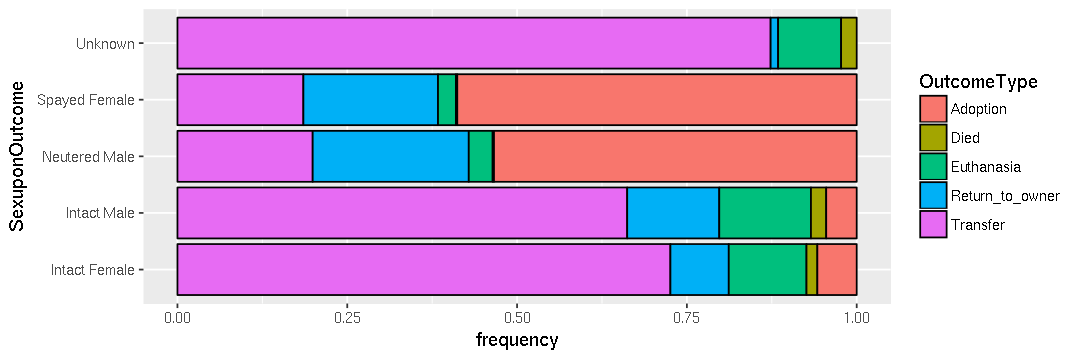

In [164]:
options(repr.plot.width=9, repr.plot.height=3)
outcomes <- dt[1:length(dt$Name),] %>%
group_by(SexuponOutcome, OutcomeType) %>%
summarise(frequency = n())
ggplot(outcomes, aes(x = SexuponOutcome, y = frequency, fill = OutcomeType)) + geom_bar(stat = 'identity', position = 'fill', colour = 'black') + coord_flip()

Como este atributo possui duas informações, será quebrado em dois novos atributos. Primeiro, o atributo Sex, que será 0 para fêmeas, 1 para machos e -1 para desconhecido.

In [165]:
dt2$Sex <- ifelse(dt$SexuponOutcome == 'Neutered Male', 1,
               ifelse(dt$SexuponOutcome == 'Intact Male', 1, 
                     ifelse(dt$SexuponOutcome == 'Unknown', -1, 0)))

In [166]:
dt2$AnimalID <- NULL

Agora, um segundo atributo será criado, indicando se o animal foi castrado, independentemente de ser macho ou fêmea, ou se não foi castrado ou não é sabido.

In [167]:
dt2$Castrated <- ifelse(dt$SexuponOutcome == 'Intact Male', 0,
                  ifelse(dt$SexuponOutcome == 'Intact Female', 0,
                         ifelse(dt$SexuponOutcome == 'Unknown', -1, 1)))

### AgeuponOutcome

Este atributo será transformado, para conter apenas uma única informação, na medida de dias.

In [168]:
age_upon <- data.table(AgeuponOutcome = dt$AgeuponOutcome)
age_upon <- age_upon[, c("Numero","Unidade") := tstrsplit(AgeuponOutcome," ",fixed=T)]

In [169]:
age_upon$Unidade <- gsub("year(\\w?)" ,"365", age_upon$Unidade )
age_upon$Unidade <- gsub("month(\\w?)","30",  age_upon$Unidade )
age_upon$Unidade <- gsub("week(\\w?)" ,"7",   age_upon$Unidade )
age_upon$Unidade <- gsub("day(\\w?)"  ,"1",   age_upon$Unidade )
age_upon$Unidade <- gsub("^$"         ,NA ,   age_upon$Unidade )

In [170]:
age_upon$Numero <- as.numeric(age_upon$Numero)
age_upon$Unidade <- as.numeric(age_upon$Unidade)
age_upon$DaysuponOutcome <- age_upon$Numero * age_upon$Unidade

Visualizando os dados, de forma normalizada e ordenada para uma melhor visualização.

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 22 rows containing non-finite values (stat_bin).”

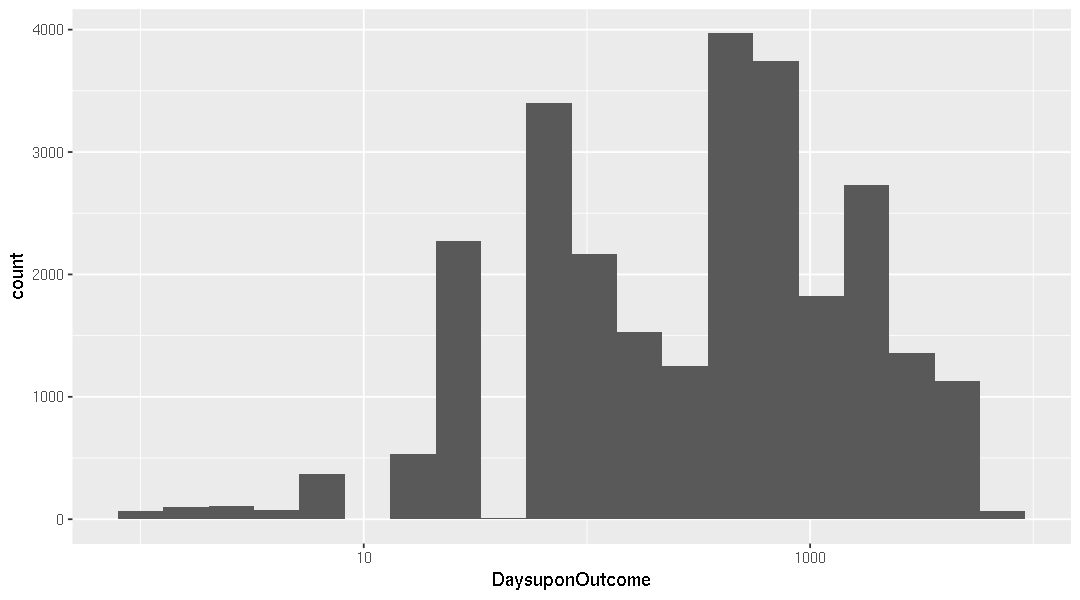

In [171]:
options(repr.plot.width=9, repr.plot.height=5)
ggplot(age_upon, aes(x=DaysuponOutcome)) + geom_histogram(bins=20) + scale_x_log10()

- Como existem muitas classes, isto poderá trazer um efeito negativo no modelo, pois isto poderá ter um
comportamento semelhante ao do ID do animal, onde a entropia é baixa mas não há um bom agrupamento com várias instâncias. Por isso, os dados serão agrupados por uma técnica de discretização.
- Optou-se neste trabalho por agrupar os animais, arbritrariamente, conforme a faixa etária. O gráfico abaixo demonstra como que as classes de faixa etária dividem os dados.

In [172]:
dt$AgerangeuponOutcome <- ifelse(age_upon$DaysuponOutcome < 360, 'Baby',
                                 ifelse(age_upon$DaysuponOutcome < 1080, 'Teenager',
                                        ifelse(age_upon$DaysuponOutcome < 2520, 'Adult', 'Ancient')))

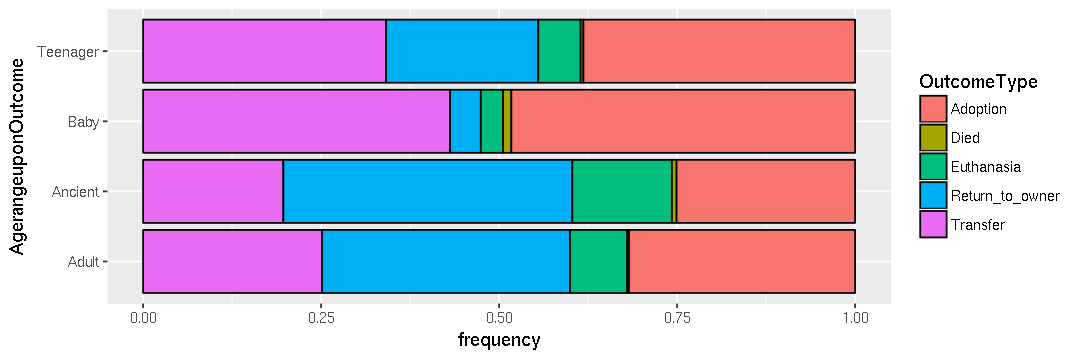

In [173]:
options(repr.plot.width=9, repr.plot.height=3)
outcomes <- dt[1:length(dt$Name),] %>%
group_by(AgerangeuponOutcome, OutcomeType) %>%
summarise(frequency = n())
ggplot(outcomes, aes(x = AgerangeuponOutcome, y = frequency, fill = OutcomeType)) + geom_bar(stat = 'identity', position = 'fill', colour = 'black') + coord_flip()

Como pode ser visto no gráfico, a maioria dos animais que retornam para o donatário são os animais anciões. O que mais frequentemente ocorre com os bebês são a transferência ou a adoção. Como pode ser visto, este agrupamento consegue separar os dados, por isto estes valores serão utilizados como entrada para o modelo.
Como a base conterá apenas valores numéricos, este novo atributo possui como classes os valores do intervalo [-1;1]

In [174]:
dt2$AgerangeuponOutcome <- ifelse(age_upon$DaysuponOutcome < 360, -1,
                                 ifelse(age_upon$DaysuponOutcome < 1080, -0.3,
                                        ifelse(age_upon$DaysuponOutcome < 2520, 0.3, 1)))

### Breed

Este atributo possui duas informações: a raça do animal e se ele é de raça pura ou mestiço. Por isso, este atributo será separado em dois.

Aqui, será analisado se a raça é pura ou não.

In [175]:
Mix <- ifelse(grepl('Mix', dt$Breed), 1,
             ifelse(grepl('/', dt$Breed), 1, 0))

Aqui será retirado a informação sobre a raça ser pura ou não. Em seguida, como ainda restarão muitas raças,
elas serão agrupadas. Por fim, os dados categóricos serão transformados em dados numéricos.

In [176]:
breeds <- dt2
breeds$Sex <- NULL
breeds$AnimalType <- dt$AnimalType
breeds$Castrated <- NULL

Retirando a informação sobre a raça ser mista.

In [177]:
aux <- gsub(" Mix", "", dt$Breed)
breeds$breed <- strsplit(x = aux, split = "/") %>% sapply(function(x){x[1]})

Criando duas colunas, para poder diferenciar o que é raça de cão do que é raça de gato. Da forma como foi implementado, na coluna **dogs** toda raça de gato aparecerá como NA, e vice-versa

In [178]:
breeds$dogs <- ifelse(breeds$AnimalType == 'Dog', breeds$breed, NA)
breeds$cats <- ifelse(breeds$AnimalType == 'Cat', breeds$breed, NA)
breeds$OutcomeType <- dt$OutcomeType

In [179]:
outcomes <- breeds[1:length(breeds$dogs),] %>%
group_by(dogs, OutcomeType) %>%
summarise(frequency = n())

Avaliando a distribuição de das classes de OutcomType entre cada classe de Breed, filtrado pelo animal ser do tipo Dog

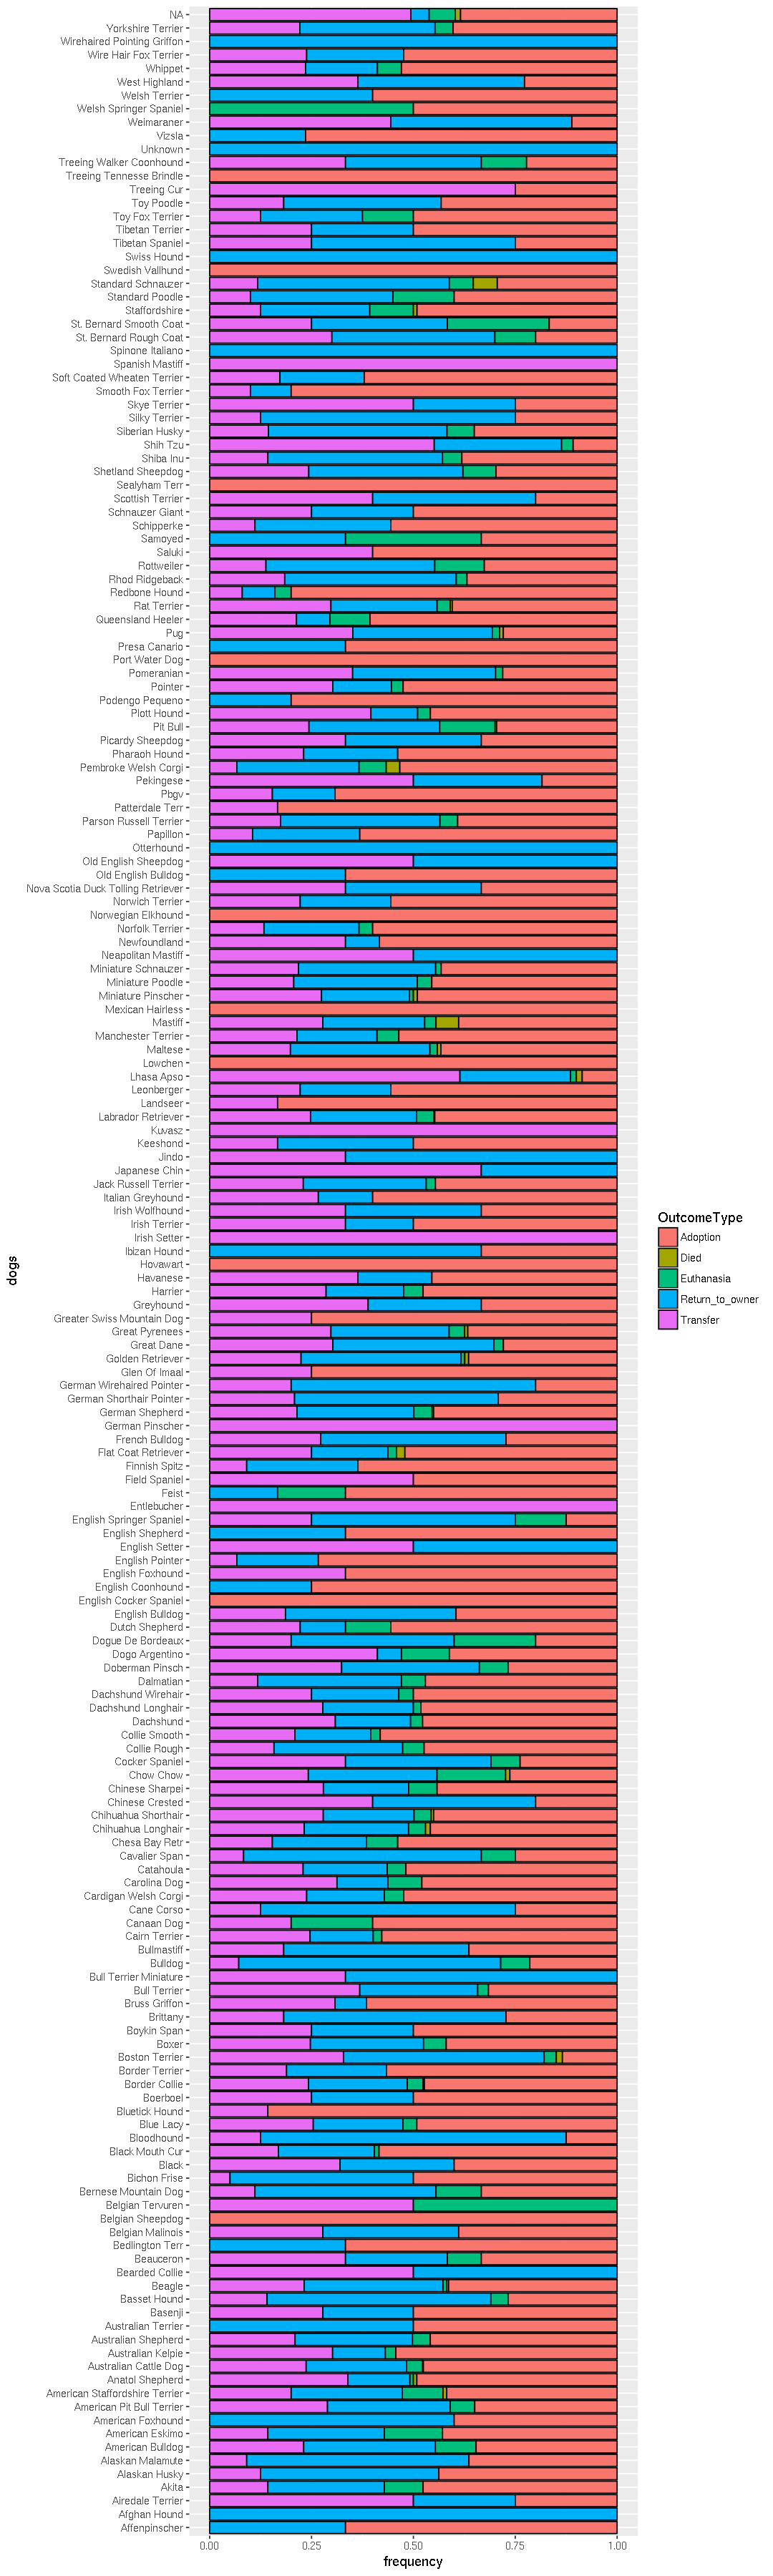

In [180]:
options(repr.plot.width=9, repr.plot.height=30)
ggplot(outcomes, aes(x = dogs, y = frequency, fill = OutcomeType)) + geom_bar(stat = 'identity', position = 'fill', colour = 'black') + coord_flip()

Por fim, descobrindo quais são as raças de cães mais populares, por meio de uma filtragem. Aquelas raças que possuem uma frequência menor que 350, serão agrupadas.

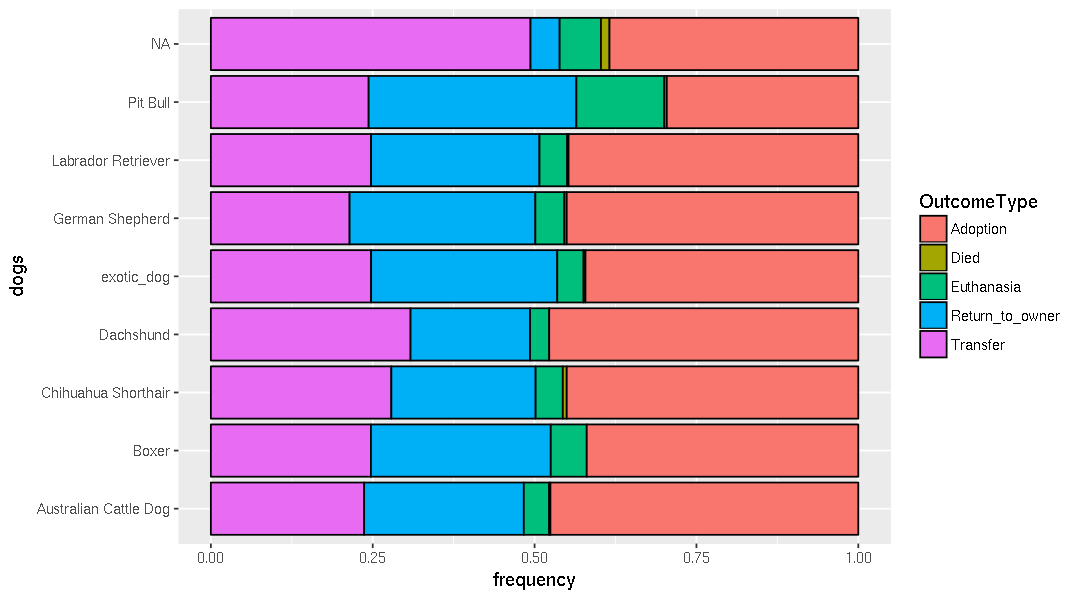

In [181]:
count(breeds, dogs) %>%
    arrange(desc(n)) %>%
    filter(n >350) -> popular

breeds$dogs[!(breeds$dogs %in% popular$dogs)] <- "exotic_dog"


outcomes <- breeds[1:length(breeds$dogs),] %>%
group_by(dogs, OutcomeType) %>%
summarise(frequency = n())
options(repr.plot.width=9, repr.plot.height=5)
ggplot(outcomes, aes(x = dogs, y = frequency, fill = OutcomeType)) + geom_bar(stat = 'identity', position = 'fill', colour = 'black') + coord_flip()

Avaliando gráficamente como ficou a distribuição dos cães.

Avaliando a distribuição de das classes de OutcomType entre cada classe de Breed, filtrado pelo animal ser do tipo Cat

In [182]:
outcomes <- breeds[1:length(breeds$cats),] %>%
group_by(cats, OutcomeType) %>%
summarise(frequency = n())

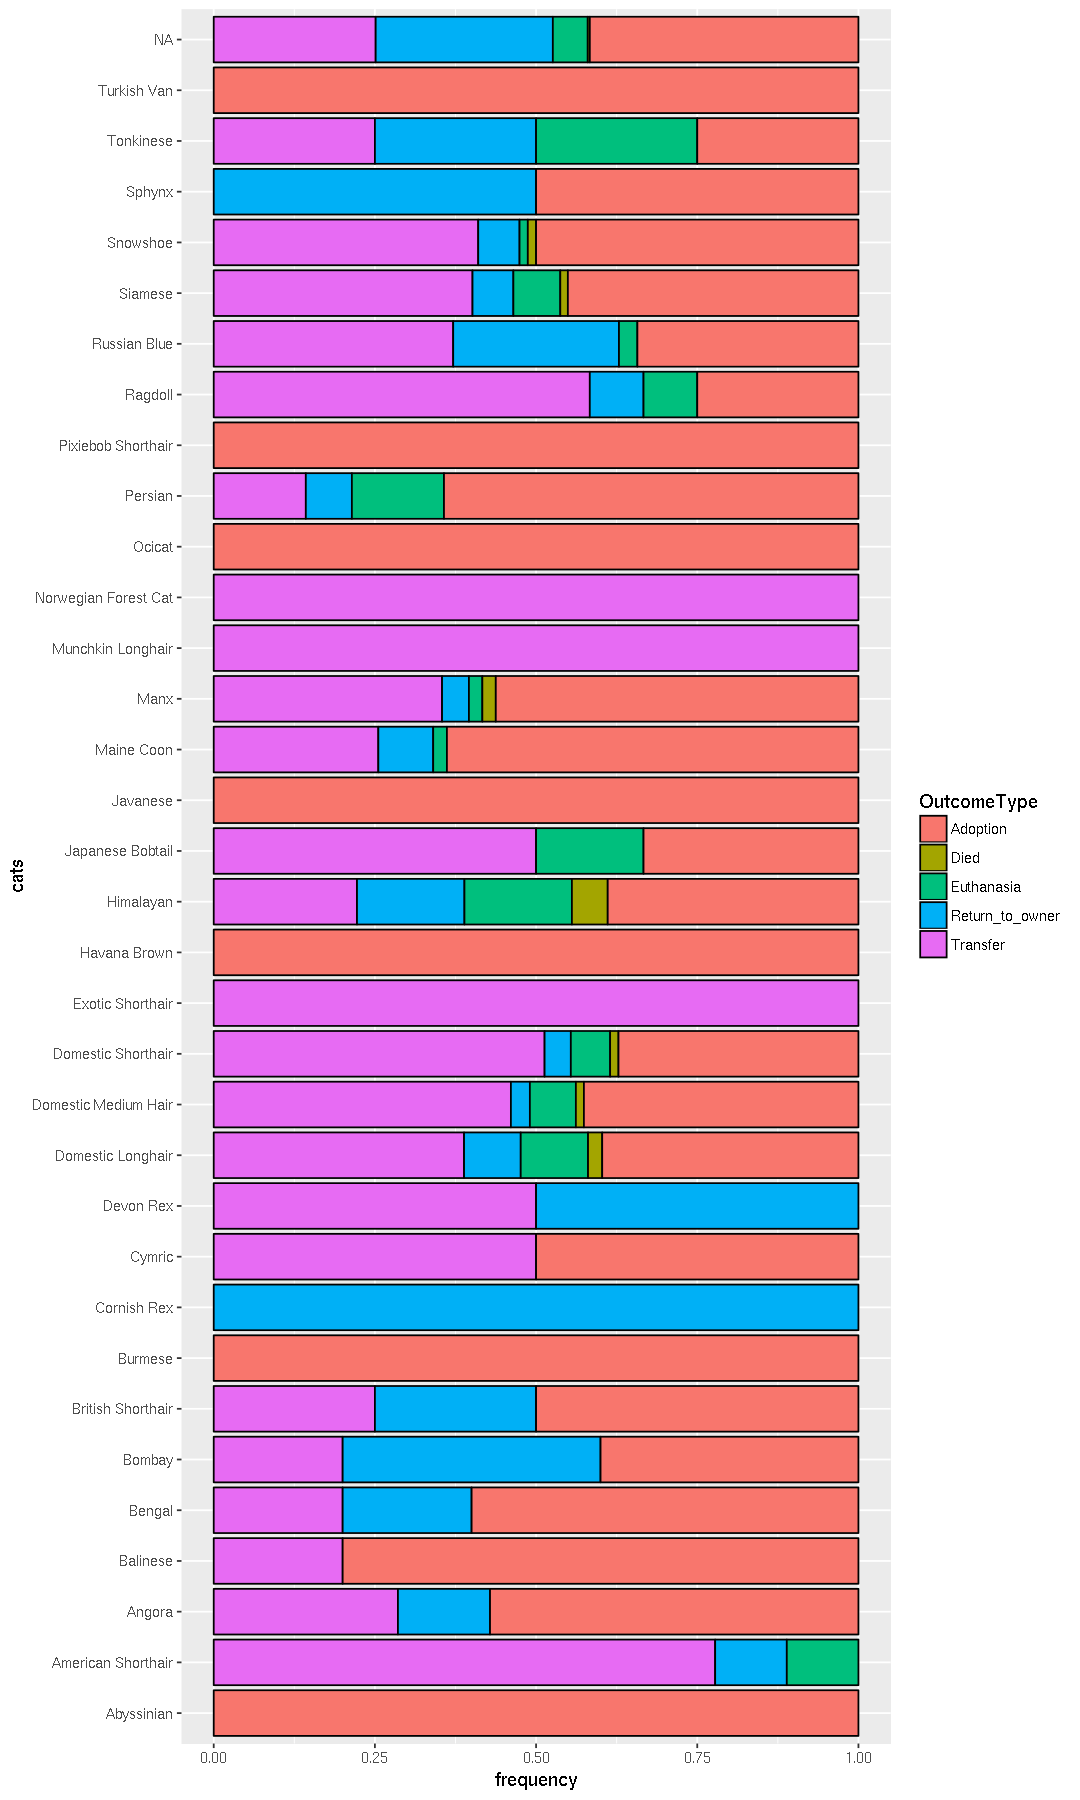

In [183]:
options(repr.plot.width=9, repr.plot.height=15)
ggplot(outcomes, aes(x = cats, y = frequency, fill = OutcomeType)) + geom_bar(stat = 'identity', position = 'fill', colour = 'black') + coord_flip()

Por fim, descobrindo quais são as raças de gatos mais populares, por meio de uma filtragem. Aquelas raças que possuem uma frequência menor que 200, serão agrupadas.

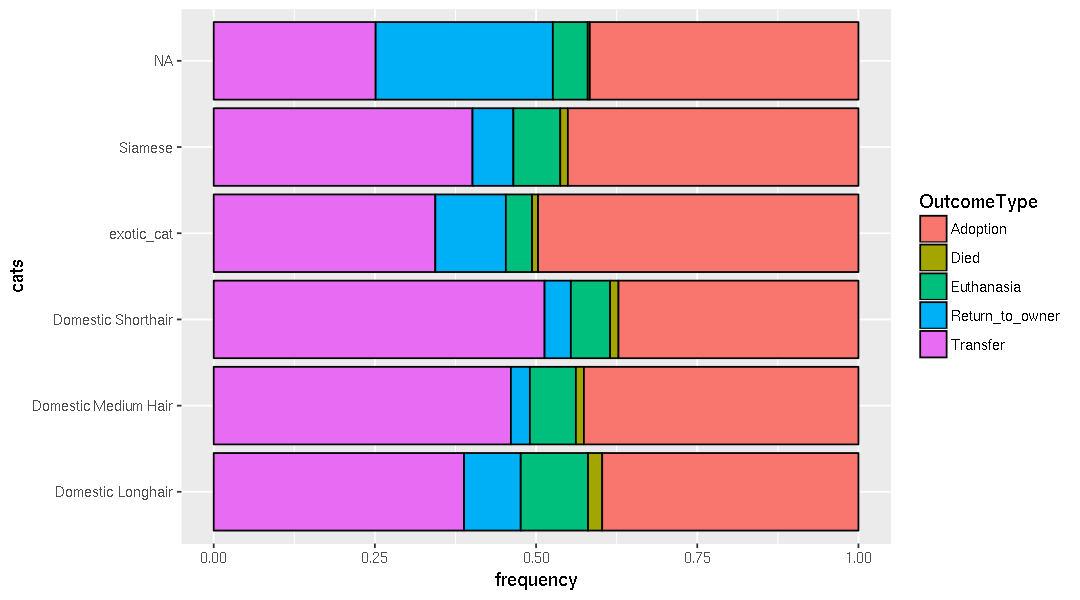

In [184]:
count(breeds, cats) %>%
    arrange(desc(n)) %>%
    filter(n >200) -> popular

breeds$cats[!(breeds$cats %in% popular$cats)] <- "exotic_cat"

outcomes <- breeds[1:length(breeds$cats),] %>%
group_by(cats, OutcomeType) %>%
summarise(frequency = n())
options(repr.plot.width=9, repr.plot.height=5)
ggplot(outcomes, aes(x = cats, y = frequency, fill = OutcomeType)) + geom_bar(stat = 'identity', position = 'fill', colour = 'black') + coord_flip()

Agora sim, as raças serão construídas em **dt2**. Somente as raças mais populares de cães e gatos permanecerão, enquanto que as impopulares foram agrupadas.

In [185]:
Unified_Breed <- ifelse(breeds$AnimalType == 'Dog', breeds$dogs, breeds$cats)
dt3 <- dt2
dt3$aux <- Unified_Breed
dt3$AnimalType <- dt$AnimalType

Desta vez faremos diferente. Vamos numerar as classes, mas de forma agrupada, para que não haja uma intercalação entre raças de cães com de gatos. Desta forma, ao normalizar, as classes estarão mais bem separadas (cães de gatos). Também vamos pôr números negativos, para que a transformação linear deixe as classes mais espaçadas entre si e o modelo tenha uma habilidade maior em tratar os dados.

In [186]:
dt3 <- dt3[order(dt3$AnimalType)]

In [187]:
classes <- unique(dt3$aux)

In [188]:
head(classes, length(classes))

[1] "Domestic Shorthair"    "exotic_cat"            "Domestic Longhair"    
 [4] "Siamese"               "Domestic Medium Hair"  "exotic_dog"           
 [7] "Pit Bull"              "German Shepherd"       "Chihuahua Shorthair"  
[10] "Labrador Retriever"    "Dachshund"             "Boxer"                
[13] "Australian Cattle Dog"

In [189]:
numeric_classes <- c(1:length(classes))

In [190]:
normalized_classes <- c(-1, -0.85, -0.7, -0.55, -0.4, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1)

In [191]:
dt2$Breed <- mapeamento(Unified_Breed, classes, normalized_classes)

In [192]:
dt2$Mix_Breed <- Mix

### AnimalType

Aqui será simples, basta transformar os dados categóricos para numéricos. Se for um cão, será 1. Se for um gato, será 0.

In [193]:
dt2$AnimalType <- ifelse(dt$AnimalType == 'Dog', 1, 0)

### OutcomeType

Vamos visualizar como ficou no final **dt2**

In [194]:
head(dt2, 30)

Name Sex Castrated AgerangeuponOutcome Breed  Mix_Breed AnimalType
1  1     1   1        -0.3                 0.125 1         1         
2  1     0   1        -0.3                -1.000 1         0         
3  1     1   1        -0.3                 0.250 1         1         
4  0     1   0        -1.0                -1.000 1         0         
5  0     1   1        -0.3                 0.125 1         1         
6  1     0   0        -1.0                 0.125 1         1         
7  1     1   0        -1.0                -1.000 1         0         
8  0    -1  -1        -1.0                -1.000 1         0         
9  1     0   1        -1.0                 0.125 1         1         
10 0     0   1        -0.3                 0.125 0         1         
11 0    -1  -1        -0.3                -1.000 1         0         
12 0     0   1        -0.3                 0.125 1         1         
13 1     1   1         0.3                 0.250 1         1         
14 1     1   1        -0.3                 0.125 1         1         
15 1     1   1        -0.3                 0.125 1         1         
16 1     1   1        -1.0                -1.000 1         0         
17 0     1   0        -1.0                -1.000 1         0         
18 0     0   0        -1.0                 0.250 1         1         
19 1     0   0        -0.3                -0.850 1         0         
20 1     1   1        -0.3                 0.125 1         1         
21 1     1   0        -1.0                 0.125 1         1         
22 1     0   1        -0.3                -1.000 1         0         
23 1     0   1        -0.3                 0.125 1         1         
24 1     1   1        -1.0                 0.375 1         1         
25 1     1   1        -1.0                 0.375 1         1         
26 1     0   0        -1.0                -1.000 1         0         
27 1     0   1        -1.0                 0.125 1         1         
28 1     0   1         0.3                 0.500 1         1         
29 1     0   1        -1.0                -1.000 1         0         
30 1     1   1         1.0                -0.850 1         0

Desta vez, teremos apenas uma única tabela.

In [195]:
dt2$OT1 <- ifelse(dt$OutcomeType == 'Return_to_owner', 1, 0)
dt2$OT2 <- ifelse(dt$OutcomeType == 'Euthanasia', 1, 0)
dt2$OT3 <- ifelse(dt$OutcomeType == 'Adoption', 1, 0)
dt2$OT4 <- ifelse(dt$OutcomeType == 'Transfer', 1, 0)
dt2$OT5 <- ifelse(dt$OutcomeType == 'Died', 1, 0)

In [196]:
write.csv(dt2, "train/Train_ANN_2.csv")